# Курсовая работа.

Малков Кирилл Евгеньвич. М8О-114СВ-24

Набор данных: https://www.kaggle.com/datasets/rishikeshkonapure/home-loan-approval?resource=download

Одобрение ипотечных кредитов

Слайды:

1. Краткое описание датасета, для чего, краткий кусок в качестве примера данных (нужен экземпляр данных). *Показать dataloader - dataloadr класс/конструкция, которая для конкретного датасета предоставляет API доступ к данным, доступ на лету, метод разбиения данных и т.д. т.е. нужно написать парой строчек кода/функцию и если эти строчки запустить, этот метод начнёт его закачку. Датасет выложить в облако. Провести сравнение с аналогами (с другими датасетами).
2. Статистика. Нужно показать статистику по данным. Кол-во записей, кол-во полей, объём 1 записи в бит, количсетво фичей, процент разбиения на классы, количество пропусков, типы данных. DONE
3. Алгоритм. Нужно выбрать задачу (конкретную) и для этой задачи из репозитория, который мы нашли, нужно привести пример алгоритма машинного обучения, который на этом датасете может на этом датасете решить эту задачу (взять пример из статьи). benchmark: датасет, метрика, методика испытаний.
*inference - найдите пример алгоритма (или обучите сами и сохраните веса) и в свой ноутбук/презентацию, сделайте инференс на своих похожих данных, если они есть. Или на тех данных датасета, что есть.
4. Кластеризация/DR (понижение размерности) - какие бы данные вы ни взяли, данные всегда можно разбить на кластеры.
5. Outliers (выбросы) - сильно выбивающиеся данные, привести в контексте. Нужно применить стандартные методы поиска выбросов.
6. ML systems design - проектирование продакшн систем. Тот датасет и те классы алгоритмы, которые мы найдём, мы можем использовать в продакш приложений. Привести примеры, где их можно использовать, какими они обладают преимуществами и недостатками.

# Краткое описание датасета

Компания хочет автоматизировать процесс определения кредитоспособности (в режиме реального времени) на основе данных о клиентах, которые они предоставляют при заполнении онлайн-формы заявки. К таким данным относятся пол, семейное положение, образование, количество иждивенцев, доход, сумма кредита, кредитная история и другие. Чтобы автоматизировать этот процесс, они сформулировали задачу по определению сегментов клиентов, которые могут претендовать на получение кредита, чтобы целенаправленно работать с этими клиентами.



In [ ]:
!pip install kaggle

In [1]:
!pip install kaggle

# Import necessary libraries
from google.colab import drive
import os

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Статистика

In [57]:
df_train = pd.read_csv(os.path.join("/content/drive/MyDrive/fileForCollab/", 'loan_sanction_train.csv'))

df_test = pd.read_csv(os.path.join("/content/drive/MyDrive/fileForCollab/", 'loan_sanction_test.csv'))

In [58]:
print(df_train.info())

print(df_train.describe())

missing_values = df_train.isnull().sum()
print("Пропущенные значения:\n", missing_values)

print(df_train['Loan_Status'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None
       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         6

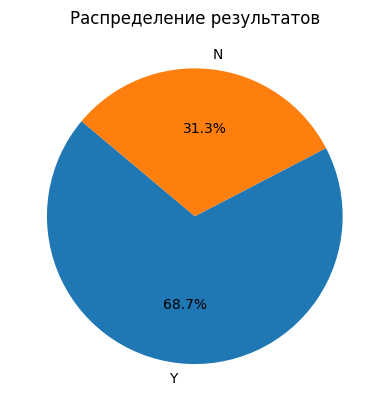

In [59]:
Approval_counts = df_train['Loan_Status'].value_counts()
plt.pie(Approval_counts, labels=Approval_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Распределение результатов')
plt.show()

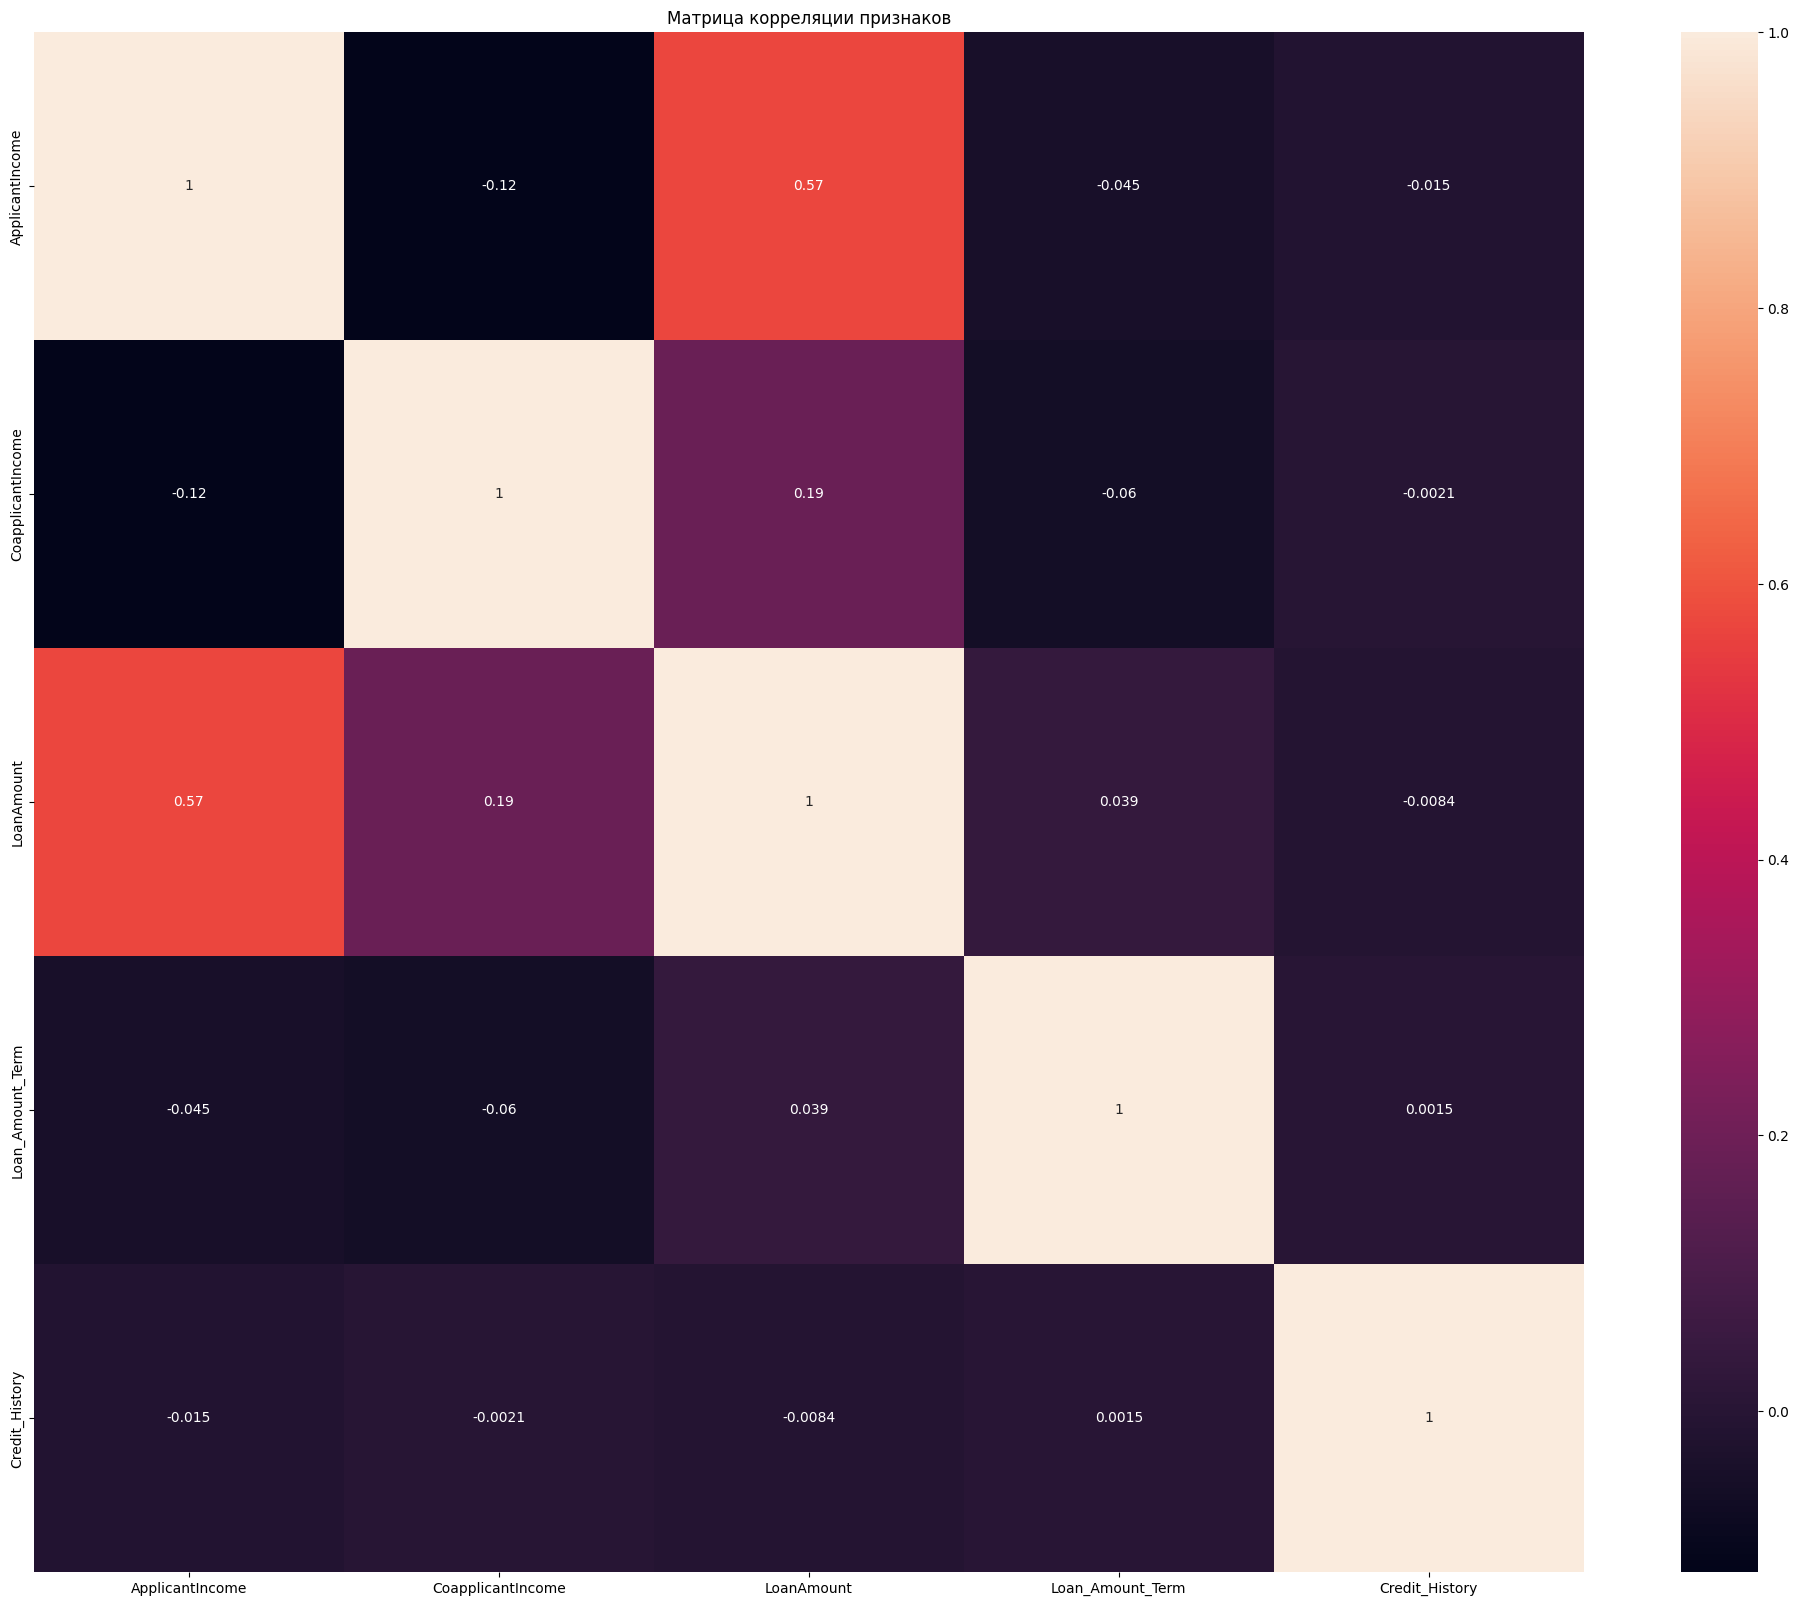

In [60]:
numerical_data = df_train.select_dtypes(include=['int64', 'float64'])
corr_matrix = numerical_data.corr()
plt.figure(figsize=(25, 20))
sns.heatmap(corr_matrix, annot=True)
plt.title('Матрица корреляции признаков')
plt.show()

# DataLoader

In [41]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import os
from sklearn.preprocessing import MinMaxScaler
import pickle

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

class LoanDataset(Dataset):
    def __init__(self, data_path, train=True, transform=None):
        self.data_path = data_path
        self.train = train
        self.transform = transform
        self.models = {}

        if train:
            self.df = pd.read_csv(os.path.join(self.data_path, 'loan_sanction_train.csv'))
        else:
            self.df = pd.read_csv(os.path.join(self.data_path, 'loan_sanction_test.csv'))
        columns_to_fill = ['Gender', 'Married', 'Dependents','Self_Employed','LoanAmount','Loan_Amount_Term','Credit_History']
        for column in columns_to_fill:
            mode_value = self.df[column].mode()[0]
            self.df[column].fillna(mode_value, inplace=True)

        le1 = preprocessing.LabelEncoder()
        self.df['Gender'] =le1.fit_transform(self.df['Gender'])
        le2 = preprocessing.LabelEncoder()
        self.df['Married'] =le2.fit_transform(self.df['Married'])
        le3 = preprocessing.LabelEncoder()
        self.df['Dependents'] =le3.fit_transform(self.df['Dependents'])
        le4 = preprocessing.LabelEncoder()
        self.df['Education'] =le4.fit_transform(self.df['Education'])
        le5 = preprocessing.LabelEncoder()
        self.df['Self_Employed'] =le5.fit_transform(self.df['Self_Employed'])
        le6 = preprocessing.LabelEncoder()
        self.df['Property_Area'] =le6.fit_transform(self.df['Property_Area'])

        self.df = self.df.drop(['Loan_ID'], axis=1)

        scaler = MinMaxScaler()
        if train:
            le7 = preprocessing.LabelEncoder()
            self.df['Loan_Status'] =le7.fit_transform(self.df['Loan_Status'])

            y = self.df['Loan_Status']
            x = scaler.fit_transform(self.df.drop('Loan_Status', axis=1)  )


            self.X_train, self.X_test, self.Y_train, self.Y_test= train_test_split(x,y, test_size=0.3, shuffle = True, random_state=42)
        else:
            # self.y = self.df['Loan_Status']
            # self.X = scaler.fit_transform(self.df.drop('Loan_Status', axis=1))
            self.X = scaler.fit_transform(self.df)




    def get_X_test(self):
        return self.X_test

    def get_Y_test(self):
        return self.Y_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if self.train:
            features = self.df.iloc[idx, :-1].values
            label = self.df.iloc[idx, -1]
            return features, label
        else:
            features = self.df.iloc[idx, :].values
            return features

    def get_df(self):
        return self.df

    def train_svm(self, kernel="linear", C=1.0):
        svm_model = SVC(kernel=kernel, C=C, probability=True)
        svm_model.fit(self.X_train, self.Y_train)
        self.models['svm'] = svm_model
        print("SVM-модель обучена.")
        return svm_model

    def train_random_forest(self, n_estimators=100, max_depth=None):
        """Обучает Random Forest-модель."""
        rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        rf_model.fit(self.X_train, self.Y_train)
        self.models['random_forest'] = rf_model
        print("Random Forest-модель обучена.")
        return rf_model

    def evaluate_model(self, model_name):
        """Оценивает точность модели."""
        if model_name not in self.models:
            raise ValueError(f"Модель '{model_name}' не найдена.")

        model = self.models[model_name]
        y_pred = model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        print(f"Точность модели '{model_name}': {accuracy:.4f}")
        return accuracy

    def predict(self, model_name, X_new):
        if model_name not in self.models:
            raise ValueError(f"Модель '{model_name}' не найдена.")

        model = self.models[model_name]
        predictions = model.predict(X_new)
        print(f"Предсказания модели '{model_name}': {predictions}")
        return predictions

    def save_model(self, model_name, file_path):
        if model_name not in self.models:
            raise ValueError(f"Модель '{model_name}' не найдена.")

        with open(file_path, 'wb') as f:
            pickle.dump(self.models[model_name], f)
        print(f"Модель '{model_name}' сохранена в '{file_path}'.")

    def load_model(self, model_name, file_path):
        with open(file_path, 'rb') as f:
            self.models[model_name] = pickle.load(f)
        print(f"Модель '{model_name}' загружена из '{file_path}'.")
        return self.models[model_name]




def get_data_loaders(data_path, batch_size=32):
  train_dataset = LoanDataset(data_path, train=True)
  test_dataset = LoanDataset(data_path, train=False)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  return train_loader, test_loader

In [9]:
import numpy as nз
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# df_test=pd.read_csv("/content/drive/MyDrive/fileForCollab/1/loan_sanction_test.csv")
# df_train=pd.read_csv("/content/drive/MyDrive/fileForCollab/1/loan_sanction_train.csv")

In [42]:
train_loader, test_loader = get_data_loaders("/content/drive/MyDrive/fileForCollab/")

In [33]:
df_train = train_loader.dataset.get_df()
df_test = test_loader.dataset.get_df()

In [30]:
df_test

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,1,1,0,0,0,5720,0,110.0,360.0,1.0,2
1,1,1,1,0,0,3076,1500,126.0,360.0,1.0,2
2,1,1,2,0,0,5000,1800,208.0,360.0,1.0,2
3,1,1,2,0,0,2340,2546,100.0,360.0,1.0,2
4,1,0,0,1,0,3276,0,78.0,360.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...
362,1,1,3,1,1,4009,1777,113.0,360.0,1.0,2
363,1,1,0,0,0,4158,709,115.0,360.0,1.0,2
364,1,0,0,0,0,3250,1993,126.0,360.0,1.0,1
365,1,1,0,0,0,5000,2393,158.0,360.0,1.0,0


# Алгоритм

In [43]:
model_path_svc = "/content/drive/MyDrive/fileForCollab/svc_model.pkl"
model_path_rf = "/content/drive/MyDrive/fileForCollab/rf_model.pkl"

In [44]:
train_loader.dataset.train_svm()
train_loader.dataset.train_random_forest()

SVM-модель обучена.
Random Forest-модель обучена.


RandomForestClassifier(random_state=42)

In [46]:
Y_test = train_loader.dataset.get_Y_test()

In [48]:
Y_pred_svc = train_loader.dataset.predict('svm', train_loader.dataset.get_X_test())
Y_pred_randomf = train_loader.dataset.predict('random_forest', train_loader.dataset.get_X_test())

train_loader.dataset.save_model('svm', model_path_svc)
train_loader.dataset.save_model('random_forest', model_path_rf)

Предсказания модели 'svm': [1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1
 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0]
Предсказания модели 'random_forest': [1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1
 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1
 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 1 1 1 0]
Модель 'svm' сохранена в '/content/drive/MyDrive/fileForCollab/svc_model.pkl'.
Модель 'random_forest' сохранена в '/content/drive/MyDrive/fileForCollab/rf_model.pkl'.


In [49]:
import pickle

loaded_svc_model = train_loader.dataset.load_model('svm', model_path_svc)
loaded_rf_model = train_loader.dataset.load_model('random_forest', model_path_rf)

Модель 'svm' загружена из '/content/drive/MyDrive/fileForCollab/svc_model.pkl'.
Модель 'random_forest' загружена из '/content/drive/MyDrive/fileForCollab/rf_model.pkl'.


In [50]:
print("SVC:")
print(accuracy_score(Y_pred_svc, Y_test))
print("Random Forest:")
print(accuracy_score(Y_pred_randomf, Y_test))

SVC:
0.7837837837837838
Random Forest:
0.772972972972973


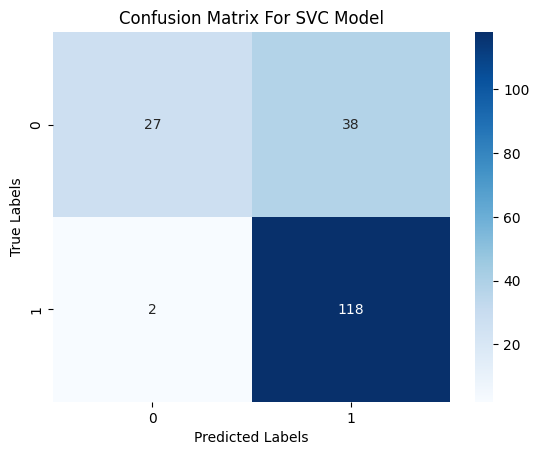

In [51]:
cm_svc = confusion_matrix(Y_test, Y_pred_svc)
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1' ])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For SVC Model')
plt.show()

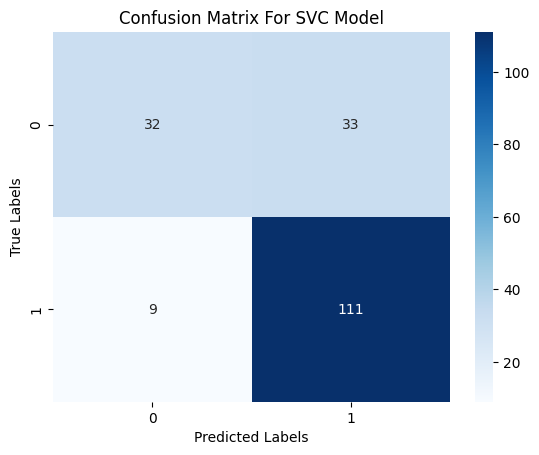

In [52]:
cm_svc = confusion_matrix(Y_test, Y_pred_randomf)
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1' ])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For SVC Model')
plt.show()

In [53]:
print(classification_report(Y_pred_svc, Y_test))

              precision    recall  f1-score   support

           0       0.42      0.93      0.57        29
           1       0.98      0.76      0.86       156

    accuracy                           0.78       185
   macro avg       0.70      0.84      0.71       185
weighted avg       0.89      0.78      0.81       185



In [54]:
print(classification_report(Y_pred_randomf, Y_test))

              precision    recall  f1-score   support

           0       0.49      0.78      0.60        41
           1       0.93      0.77      0.84       144

    accuracy                           0.77       185
   macro avg       0.71      0.78      0.72       185
weighted avg       0.83      0.77      0.79       185



---


# Предобработка данных

In [20]:
columns_to_fill = ['Gender', 'Married', 'Dependents','Self_Employed','LoanAmount','Loan_Amount_Term','Credit_History']
for column in columns_to_fill:
    mode_value = df_train[column].mode()[0]
    df_train[column].fillna(mode_value, inplace=True)

In [21]:
columns_to_fill_test = ['Gender', 'Married', 'Dependents','Self_Employed','LoanAmount','Loan_Amount_Term','Credit_History']
for column in columns_to_fill_test:
    mode_value = df_test[column].mode()[0]
    df_test[column].fillna(mode_value, inplace=True)

In [22]:
le1 = preprocessing.LabelEncoder()
df_train['Gender'] =le1.fit_transform(df_train['Gender'])
le2 = preprocessing.LabelEncoder()
df_train['Married'] =le2.fit_transform(df_train['Married'])
le3 = preprocessing.LabelEncoder()
df_train['Dependents'] =le3.fit_transform(df_train['Dependents'])
le4 = preprocessing.LabelEncoder()
df_train['Education'] =le4.fit_transform(df_train['Education'])
le5 = preprocessing.LabelEncoder()
df_train['Self_Employed'] =le5.fit_transform(df_train['Self_Employed'])
le6 = preprocessing.LabelEncoder()
df_train['Property_Area'] =le6.fit_transform(df_train['Property_Area'])
le7 = preprocessing.LabelEncoder()
df_train['Loan_Status'] =le7.fit_transform(df_train['Loan_Status'])

---


In [26]:
df = df_train
X = df.drop(columns=['Loan_Status'])
y = df['Loan_Status']

# Кластеризация

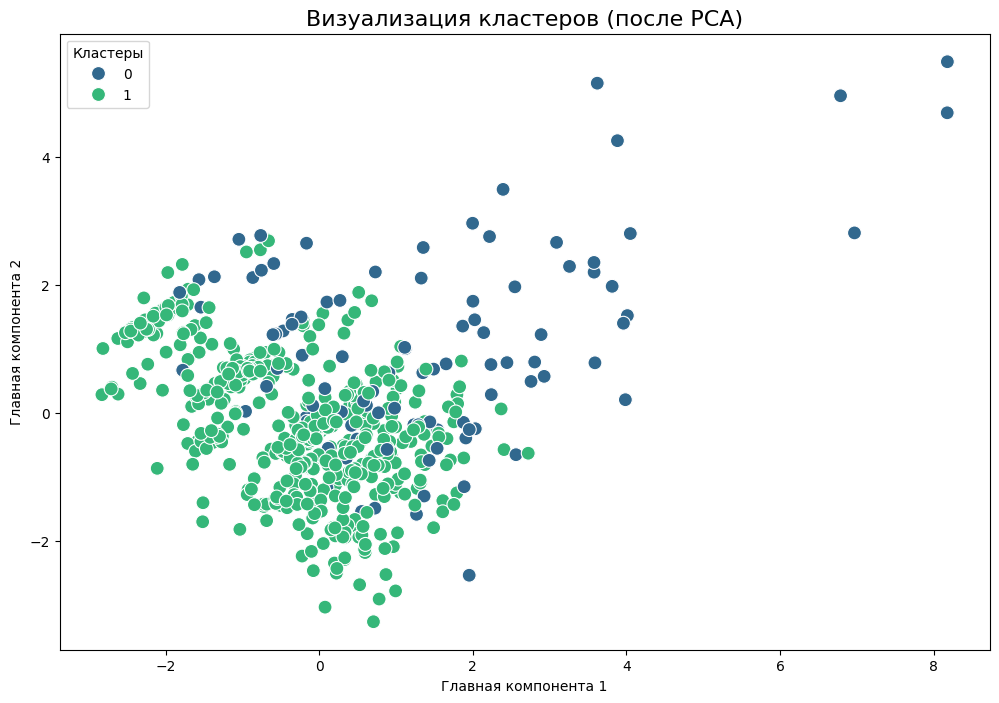

In [30]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

numeric_features = X.select_dtypes(include=["float64", "int64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

n_clusters = 2
kmeans_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("kmeans", KMeans(n_clusters=n_clusters, random_state=42))])
kmeans_pipeline.fit(X)

cluster_labels = kmeans_pipeline["kmeans"].labels_

pca = PCA(n_components=2, random_state=42)
X_transformed = preprocessor.fit_transform(X)
X_pca = pca.fit_transform(X_transformed)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette="viridis", s=100)
plt.title("Визуализация кластеров (после PCA)", fontsize=16)
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.legend(title="Кластеры")
plt.show()


# Поиск выбросов

Number of outliers: 68
      Loan_ID  Gender Married Dependents     Education Self_Employed  \
9    LP001020    Male     Yes          1      Graduate            No   
14   LP001030    Male     Yes          2      Graduate            No   
34   LP001100    Male      No         3+      Graduate            No   
54   LP001186  Female     Yes          1      Graduate           Yes   
62   LP001207    Male     Yes          0  Not Graduate           Yes   
..        ...     ...     ...        ...           ...           ...   
561  LP002813  Female     Yes          1      Graduate           Yes   
564  LP002832    Male     Yes          2      Graduate            No   
581  LP002893    Male      No          0      Graduate            No   
585  LP002912    Male     Yes          1      Graduate            No   
600  LP002949  Female      No         3+      Graduate           NaN   

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
9              12841            10968.0

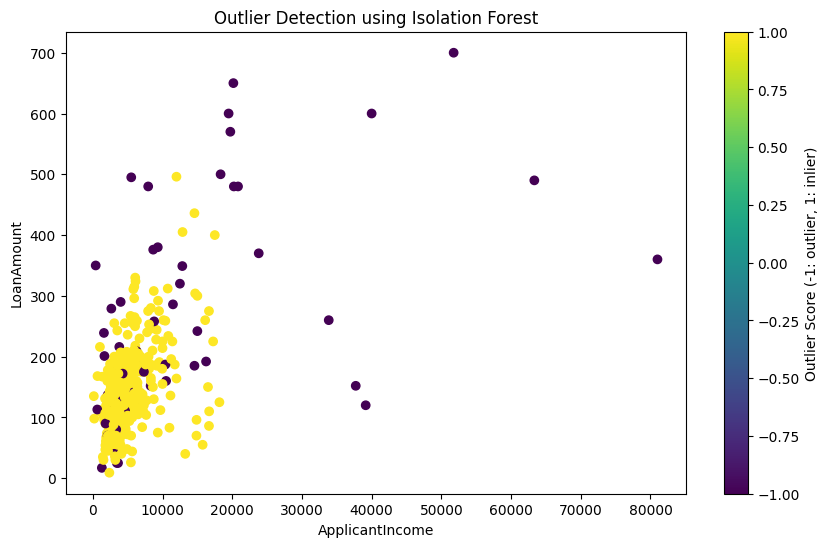

In [67]:
import pandas as pd
from sklearn.ensemble import IsolationForest

numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
X_numerical = df_train[numerical_features]

isolation_forest = IsolationForest(contamination='auto', random_state=42)

isolation_forest.fit(X_numerical)

df_train['outlier_score'] = isolation_forest.decision_function(X_numerical)
df_train['outlier'] = isolation_forest.predict(X_numerical)

outliers = df_train[df_train['outlier'] == -1]

print("Number of outliers:", len(outliers))
print(outliers)

plt.figure(figsize=(10, 6))
plt.scatter(df_train['ApplicantIncome'], df_train['LoanAmount'], c=df_train['outlier'], cmap='viridis')
plt.title('Outlier Detection using Isolation Forest')
plt.xlabel('ApplicantIncome')
plt.ylabel('LoanAmount')
plt.colorbar(label='Outlier Score (-1: outlier, 1: inlier)')
plt.show()


In [31]:
from scipy.stats import zscore

z_scores = zscore(X.select_dtypes(include=['float64', 'int64']))
outliers = (abs(z_scores) > 3).any(axis=1)

# Вывод количества выбросов
print(f"Количество выбросов: {outliers.sum()}")

Количество выбросов: 37


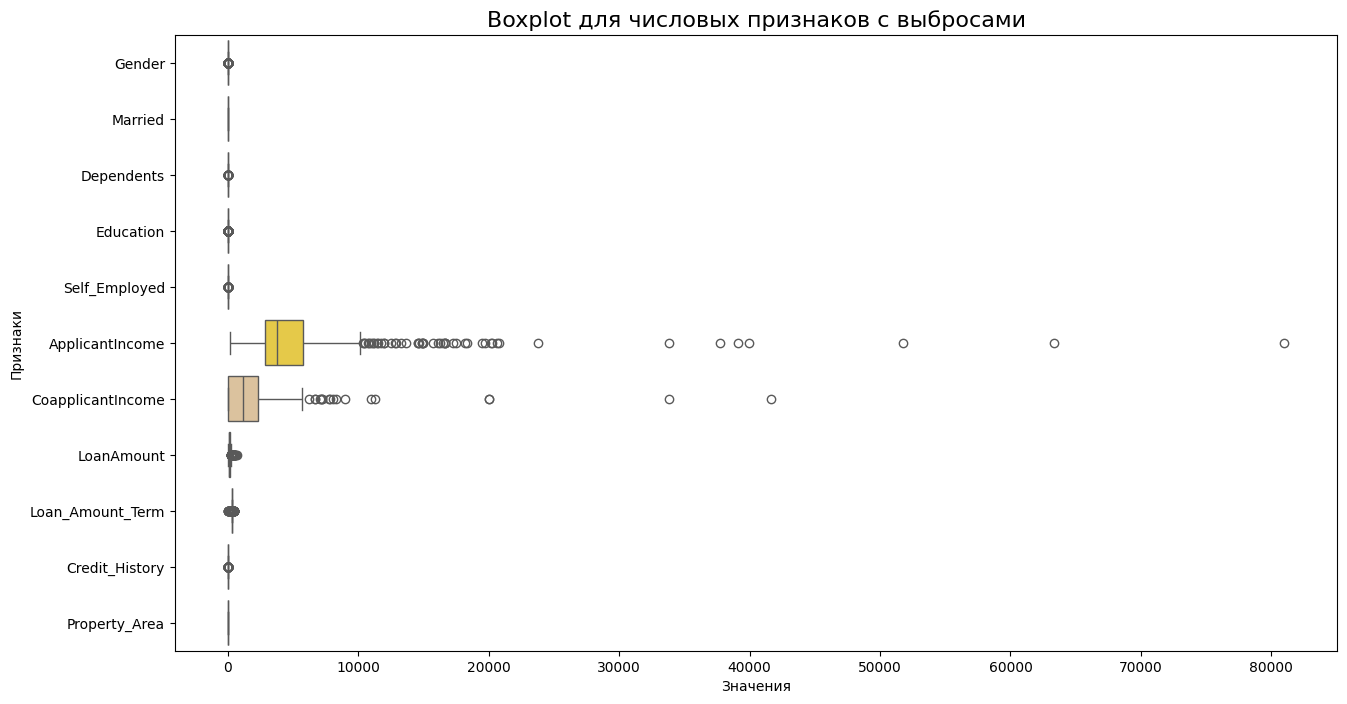

In [35]:
numeric_data = X.select_dtypes(include=['float64', 'int64'])


plt.figure(figsize=(15, 8))

sns.boxplot(data=numeric_data, orient="h", palette="Set2")

plt.title("Boxplot для числовых признаков с выбросами", fontsize=16)

plt.xlabel("Значения")

plt.ylabel("Признаки")

plt.show()

# Применение в продакшен системах

Возможные применения:

- Автоматизированные системы оценки кредитоспособности.

Преимущества:

- Снижение человеческого фактора, высокая скорость обработки заявок.
